# Lab 6 CNN's

Wyatt Saltzman and Landon Wood
Dr. Larson
CS 7324

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
%matplotlib inline

print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Tensorflow version:', tf.__version__)

Pandas version: 2.0.3
Numpy version: 1.24.3
Tensorflow version: 2.13.0


## Choose which metric we want to use...

In [18]:
IMG_HEIGHT = 32
IMG_WIDTH = 32
N_CLASSES = 10

tf.random.set_seed(2)
np.random.seed(0)
tf.config.list_physical_devices('GPU')

# Load the data
(X, y), _ = tf.keras.datasets.cifar10.load_data()

# Convert to grayscale
X = tf.image.rgb_to_grayscale(X).numpy()

# Normalize the data
X = X / 255.0

print('X_train shape:', X.shape)
print('y_train shape:', y.shape)

X_train shape: (50000, 32, 32, 1)
y_train shape: (50000, 1)


| Label | Description |
| --- | --- |
| 0 | airplane |
| 1 | automobile |
| 2 | bird |
| 3 | cat |
| 4 | deer |
| 5 | dog |
| 6 | frog |
| 7 | horse |
| 8 | ship |
| 9 | truck |

## Split the data and justify your choice of validation scheme.

In [19]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

/Users/wyattsaltzman/anaconda3/envs/ML23env/lib/python3.8/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


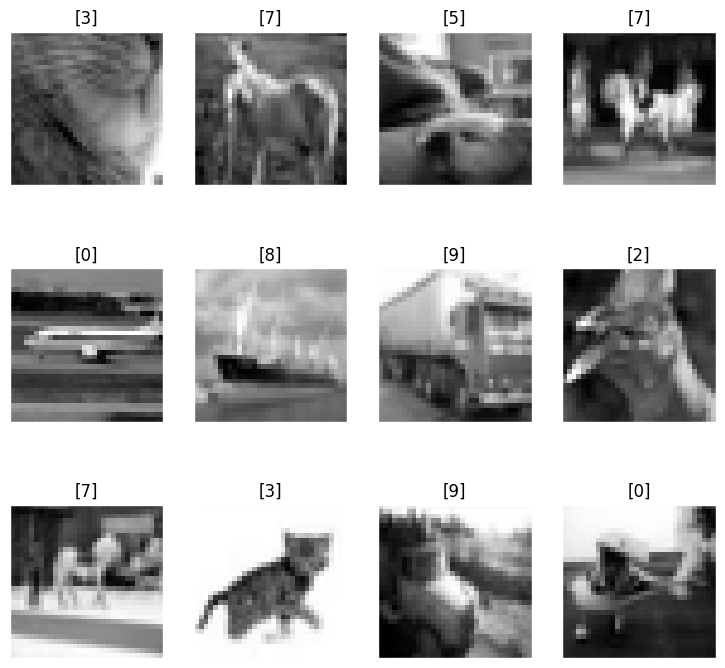

In [21]:
# Plot images
plt.style.use('ggplot')

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_train, y_train, IMG_HEIGHT, IMG_WIDTH)

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model

print('Keras version:', keras.__version__)